In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
%matplotlib inline

In [3]:
df = pd.read_csv('../data/features_seattle_911_no_dup_hoods.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.Datetime = pd.to_datetime(df.Datetime)
df.date = pd.to_datetime(df.date)

In [4]:
df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,dt_crop,date,time,...,seasonality,neighborhood,zone1,zone2,zone3,zone4,zone5,zone6,zone7,zone8
0,6900 37th Av S,Medic Response,2011-11-09 23:33:00,47.540683,-122.286131,"(47.540683, -122.286131)",F110104166,11/09/2011 11:33:00 PM,2011-11-09,23:33:00,...,0.889486,Holly Park,0,0,0,0,0,0,0,0
1,N 50th St / Stone Way N,Aid Response,2011-11-09 23:32:00,47.665034,-122.340207,"(47.665034, -122.340207)",F110104164,11/09/2011 11:32:00 PM,2011-11-09,23:32:00,...,0.889486,Wallingford,1,0,0,0,0,0,0,0
2,E John St / E Olive Way,Aid Response,2011-11-09 23:32:00,47.619575,-122.324257,"(47.619575, -122.324257)",F110104165,11/09/2011 11:32:00 PM,2011-11-09,23:32:00,...,0.889486,Broadway,0,0,0,1,0,0,0,0
3,611 12th Av S,Aid Response,2011-11-09 23:29:00,47.597406,-122.317228,"(47.597406, -122.317228)",F110104162,11/09/2011 11:29:00 PM,2011-11-09,23:29:00,...,0.889486,International District,0,0,0,0,1,0,0,0
4,4545 42nd Av Sw,Automatic Medical Alarm,2011-11-09 23:25:00,47.562472,-122.385455,"(47.562472, -122.385455)",F110104161,11/09/2011 11:25:00 PM,2011-11-09,23:25:00,...,0.889486,Genesee,0,0,0,0,0,0,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574863 entries, 0 to 574862
Data columns (total 36 columns):
Address            574854 non-null object
Type               574863 non-null object
Datetime           574863 non-null datetime64[ns]
Latitude           574863 non-null float64
Longitude          574863 non-null float64
Report Location    544399 non-null object
Incident Number    545879 non-null object
dt_crop            574863 non-null object
date               574863 non-null datetime64[ns]
time               574863 non-null object
date2              574863 non-null object
time2              574863 non-null object
mariners_home      574863 non-null int64
seahawks_home      574863 non-null int64
sounders_home      574863 non-null int64
trav_holiday       574863 non-null int64
dang_holiday       574863 non-null int64
weekday            574863 non-null object
night              574863 non-null int64
Monday             574863 non-null int64
Saturday           574863 non-null int

In [10]:
q = '''
SELECT
    strftime('%Y', date) as year
    ,strftime('%m', date) as month
FROM
    df;
'''

test = sqldf(q, globals())
test.head()

,year,month
0,2011,11
1,2011,11
2,2011,11
3,2011,11
4,2011,11


# Fill nan with 0

In [103]:
def fill_nan(counts):
    counts.date = pd.to_datetime(counts.date)
    counts = counts.set_index(counts.date)
    counts = counts.drop('date', 1)
    date_min = min(df.date)
    date_max = max(df.date)
    idx = pd.date_range(date_min, date_max)

    s = counts.freq

    s.index = pd.DatetimeIndex(s.index)

    s = s.reindex(idx, fill_value=0)

    return s

# Aid resonses in SLU area

In [130]:
q_aid = '''
SELECT
    date
    ,COUNT(Latitude) AS freq
FROM
    df
WHERE
    type = 'Aid Response'
    AND
    zone8 = 1
GROUP BY
    date;
'''

counts_aid = sqldf(q_aid, globals())

In [11]:
q_aid = '''
SELECT
    strftime('%Y', date) as year
    ,strftime('%m', date) as month
    ,COUNT(Latitude) AS freq
FROM
    df
WHERE
    type = 'Aid Response'
    AND
    zone8 = 1
GROUP BY
    year
    ,month;
'''

counts_aid = sqldf(q_aid, globals())

In [18]:
counts_aid.head()

,year,month,freq
0,2010,06,14
1,2010,07,336
2,2010,08,277
3,2010,09,272
4,2010,10,324


In [12]:
sum(counts_aid.freq)

30814

In [13]:
np.mean(counts_aid.freq)

385.175

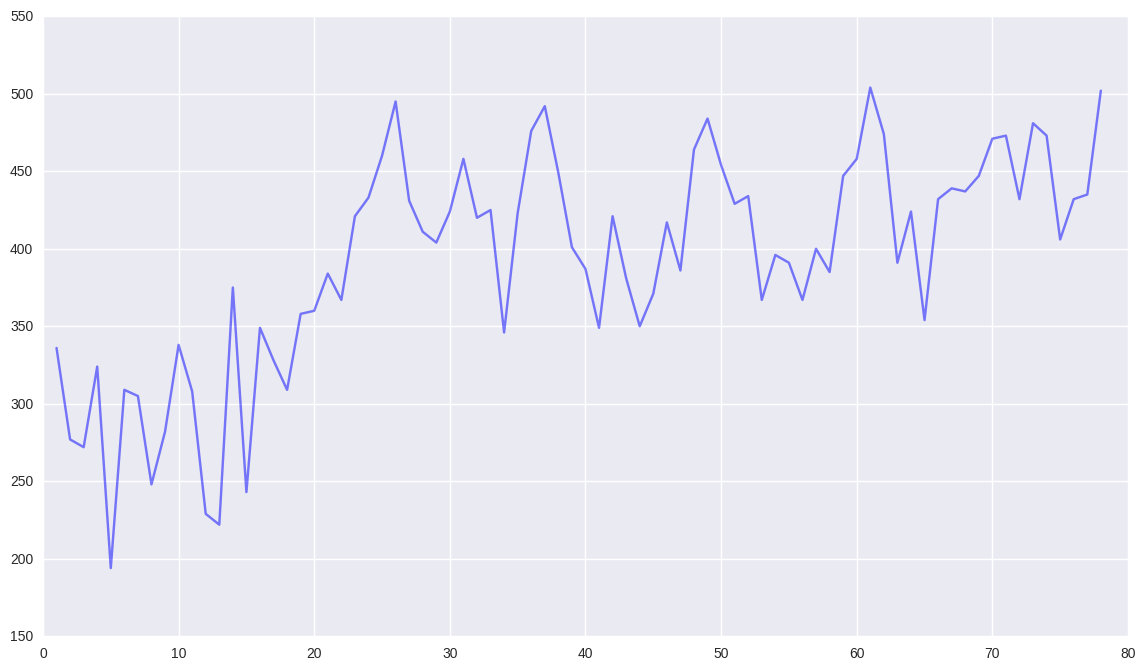

In [17]:
plt.figure(figsize=(14,8))
plt.plot(counts_aid.freq[1:-1], color='b', alpha=0.5);

# Medic responses in SLU area

In [19]:
q_medic = '''
SELECT
    strftime('%Y', date) as year
    ,strftime('%m', date) as month
    ,COUNT(Latitude) AS freq
FROM
    df
WHERE
    type = 'Medic Response'
    AND
    zone8 = 1
GROUP BY
    year
    ,month;
'''

counts_medic = sqldf(q_medic, globals())

In [20]:
counts_medic.head()

,year,month,freq
0,2010,06,10
1,2010,07,159
2,2010,08,142
3,2010,09,152
4,2010,10,160


In [22]:
sum(counts_medic.freq)

11593

In [23]:
np.mean(counts_medic.freq)

144.9125

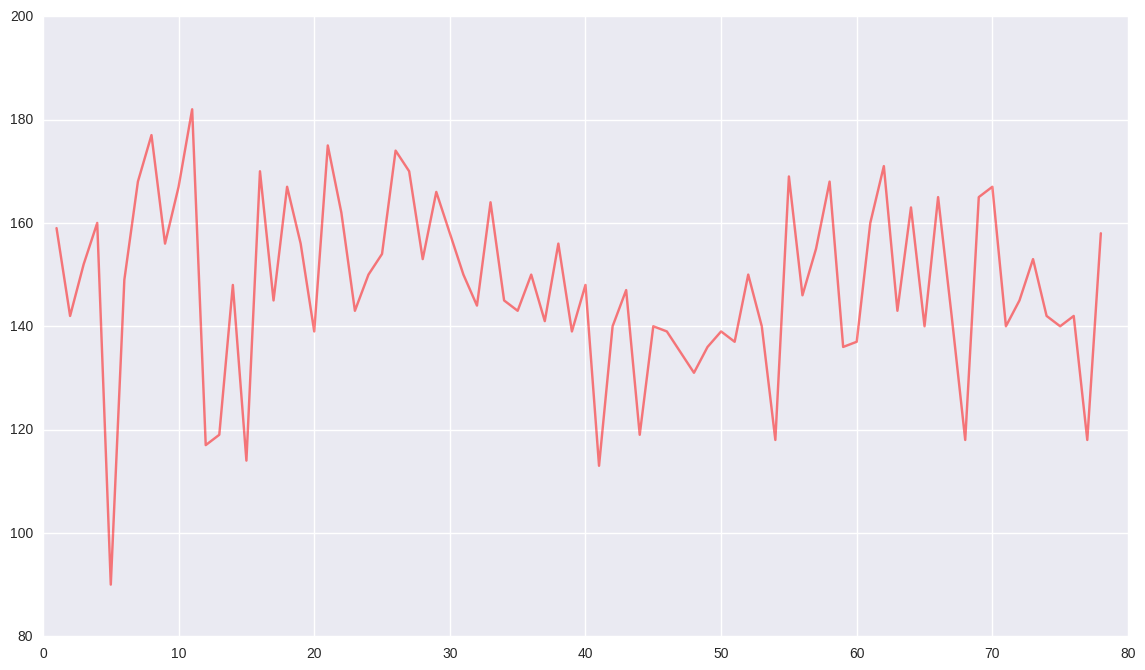

In [24]:
plt.figure(figsize=(14,8))
plt.plot(counts_medic.freq[1:-1], color='r', alpha=0.5);

# Aid repsonses SLU proper

In [27]:
q_aid = '''
SELECT
    strftime('%Y', date) as year
    ,strftime('%m', date) as month
    ,COUNT(Latitude) AS freq
FROM
    df
WHERE
    type = 'Aid Response'
    AND
    neighborhood = 'South Lake Union'
GROUP BY
    year
    ,month;
'''

counts_aid = sqldf(q_aid, globals())

In [28]:
counts_aid.head()

,year,month,freq
0,2010,06,3
1,2010,07,54
2,2010,08,44
3,2010,09,57
4,2010,10,57


In [29]:
sum(counts_aid.freq)

6641

In [30]:
np.mean(counts_aid.freq)

83.0125

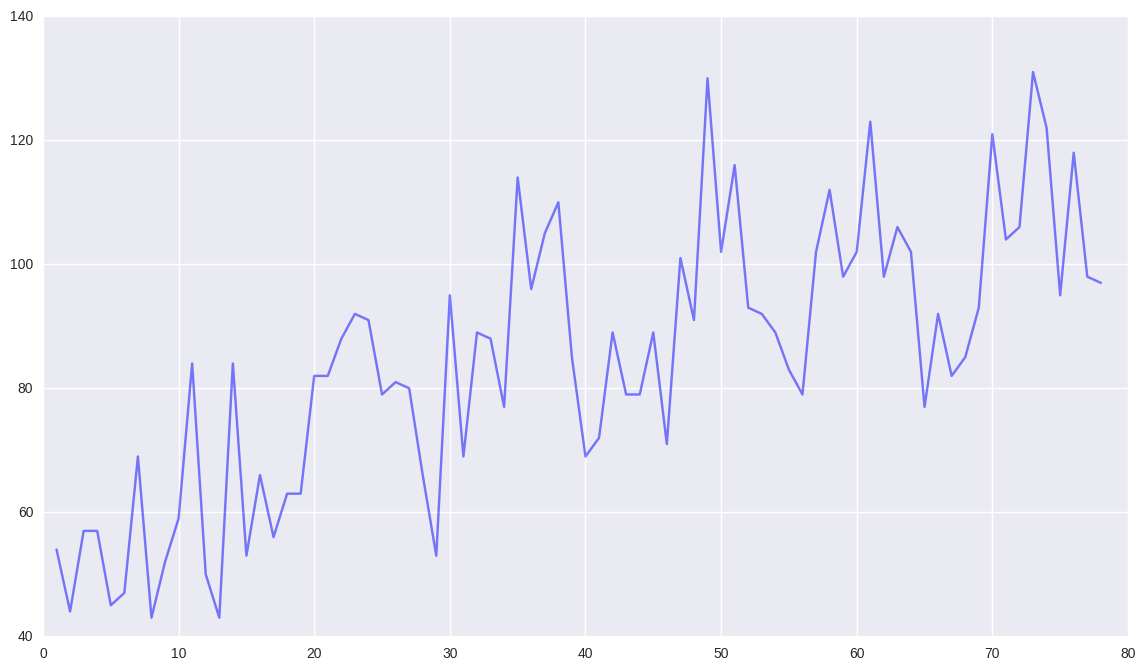

In [31]:
plt.figure(figsize=(14,8))
plt.plot(counts_aid.freq[1:-1], color='b', alpha=0.5);

# Medic responses SLU proper

In [32]:
q_medic = '''
SELECT
    strftime('%Y', date) as year
    ,strftime('%m', date) as month
    ,COUNT(Latitude) AS freq
FROM
    df
WHERE
    type = 'Medic Response'
    AND
    neighborhood = 'South Lake Union'
GROUP BY
    year
    ,month;
'''

counts_medic = sqldf(q_medic, globals())

In [33]:
counts_medic.head()

,year,month,freq
0,2010,06,1
1,2010,07,21
2,2010,08,15
3,2010,09,10
4,2010,10,24


In [35]:
sum(counts_medic.freq)

1835

In [36]:
np.mean(counts_medic.freq)

22.9375

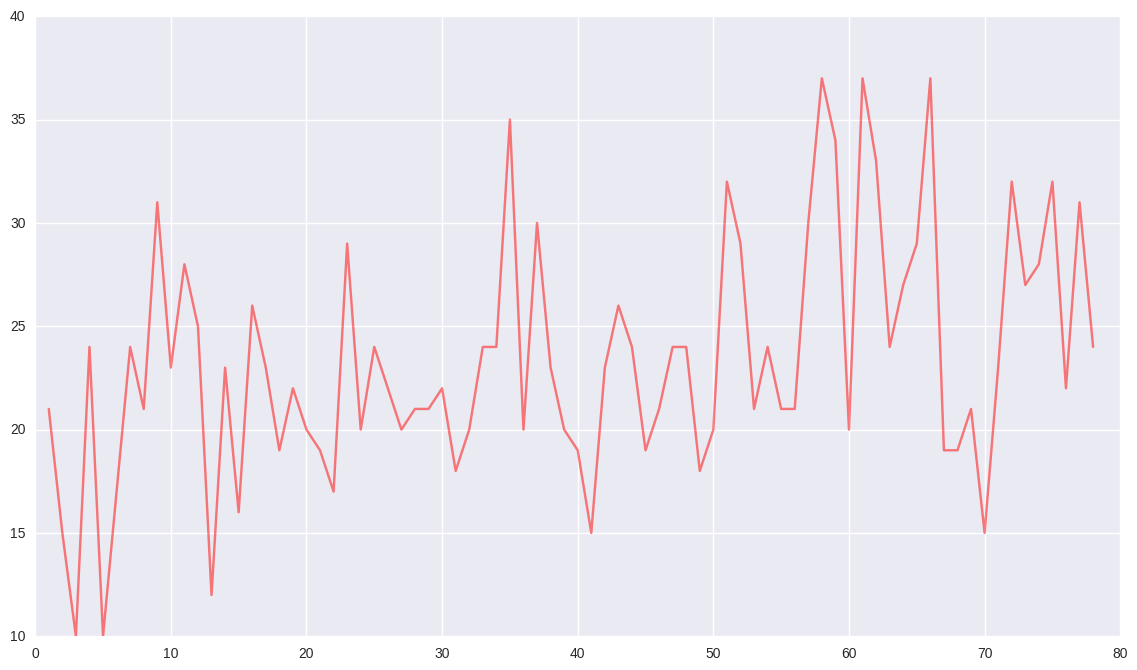

In [39]:
plt.figure(figsize=(14,8))
plt.plot(counts_medic.freq[1:-1], color='r', alpha=0.5);